# Clasificación de células cervicales en analisis de PAP en 6 clases

## 1. Importación de librerias, preparación de directorios y carga de datos

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0, ResNet50, EfficientNetB4, EfficientNetB5, MobileNetV2, InceptionV3, Xception
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from keras_tuner import HyperModel, RandomSearch

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm.keras import TqdmCallback

/Users/achula/miniconda3/envs/proyecto_final/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Gráfico de distribución de clases**

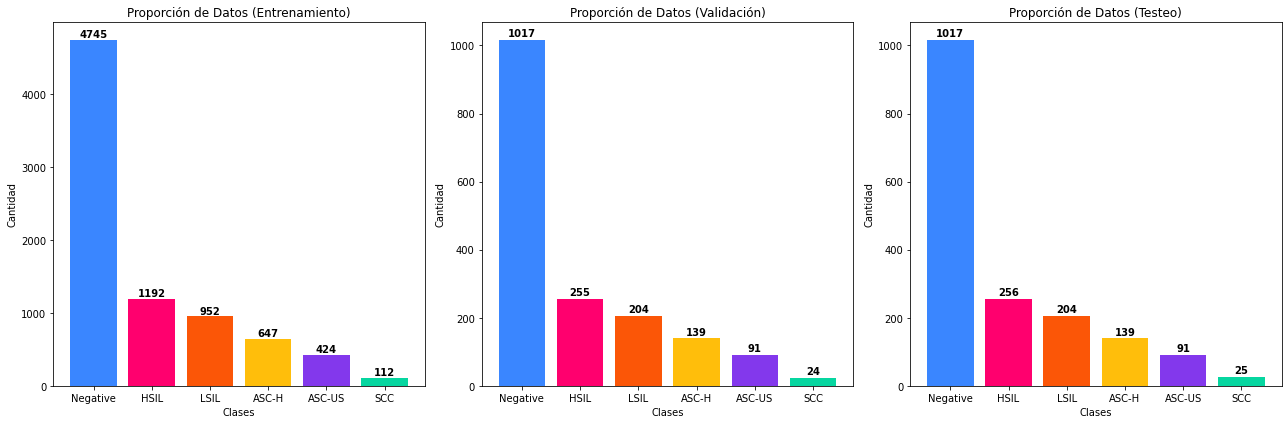

In [ ]:
# Función para contar imágenes en cada subclase dentro de '1_lesion' y '0_no_lesion'
def count_images_in_folders(base_folder):
    class_counts = defaultdict(int)
    for lesion_type in os.listdir(base_folder):
        lesion_path = os.path.join(base_folder, lesion_type)
        if os.path.isdir(lesion_path):
            for class_name in os.listdir(lesion_path):
                class_path = os.path.join(lesion_path, class_name)
                if os.path.isdir(class_path):
                    class_counts[class_name] += len(os.listdir(class_path))
    return dict(class_counts)

# Función para graficar las proporciones de las clases
def plot_class_proportion_subplot(ax, class_counts, title):
    ax.bar(class_counts.keys(), class_counts.values(), color=['#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC', '#06D6A0'])
    ax.set_xlabel('Clases')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad sobre las barras
    for i, (class_name, count) in enumerate(class_counts.items()):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento y prueba
train_dir = 'imagenes_divididas/train/'
val_dir = 'imagenes_divididas/val'
test_dir = 'imagenes_divididas/test'

# Contar las imágenes en cada conjunto
train_class_counts = count_images_in_folders(train_dir)
val_class_counts = count_images_in_folders(val_dir)
test_class_counts = count_images_in_folders(test_dir)

# Crear gráficos para los conjuntos de entrenamiento y prueba
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 2 columnas

# Gráfico para entrenamiento
plot_class_proportion_subplot(axes[0], train_class_counts, 'Proporción de Datos (Entrenamiento)')

# Gráfico para validación
plot_class_proportion_subplot(axes[1], val_class_counts, 'Proporción de Datos (Validación)')

# Gráfico para prueba
plot_class_proportion_subplot(axes[2], test_class_counts, 'Proporción de Datos (Testeo)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

## 2. Generación de imagenes

In [ ]:
# Configuración de parámetros
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de aumentación para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

# Generador sin aumentación para validación y prueba
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Crear generadores para entrenamiento, validación y prueba
train_generator = train_datagen.flow_from_directory(
    'imgs/crops_6classes/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    'imgs/crops_6classes/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    'imgs/crops_6classes/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes

Found 8072 images belonging to 6 classes.
Found 1730 images belonging to 6 classes.
Found 1732 images belonging to 6 classes.


## 3. Entrenamiento y evaluación de modelos

### Modelo EfficientNetB0

In [ ]:
# Definición del modelo EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Entrenamiento con barra de progreso
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]  
)

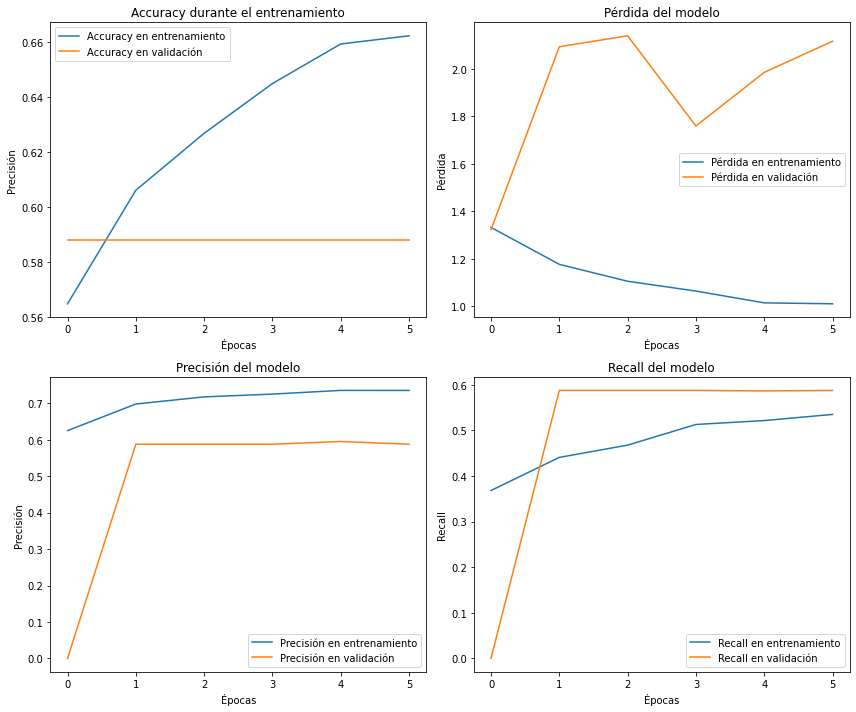

In [ ]:
# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10)) 

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  
plt.show()

**Evaluación**

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.2519 - auc: 0.6402 - f1_score: 0.6402 - loss: 1.7670 - precision: 0.0000e+00 - recall: 0.0000e+00
Pérdida en el conjunto de prueba: 1.3241541385650635
accuracy en el conjunto de prueba: 0.5871824622154236
Precision en el conjunto de prueba: 0.0
Recall en el conjunto de prueba: 0.0
AUC en el conjunto de prueba: 0.8187069892883301
F1-Score en el conjunto de prueba: 0.8187069892883301


In [ ]:
# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

In [ ]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step


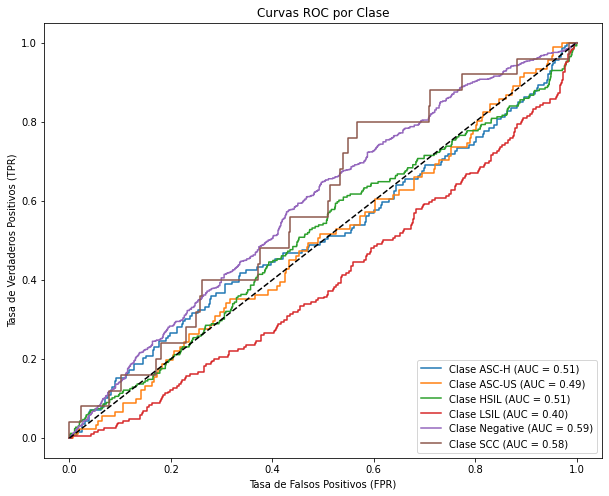

AUC Promedio: 0.51
AUC Promedio Ponderado: 0.54


In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

### Modelo EfficientNetB4

In [ ]:
# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 186s 649ms/step - accuracy: 0.5106 - auc: 0.7892 - f1_score: 0.7892 - loss: 1.3853 - precision: 0.6678 - recall: 0.2713 - val_accuracy: 0.5879 - val_auc: 0.8365 - val_f1_score: 0.8365 - val_loss: 1.2900 - val_precision: 0.6480 - val_recall: 0.0671 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 153s 602ms/step - accuracy: 0.5993 - auc: 0.8634 - f1_score: 0.8634 - loss: 1.1451 - precision: 0.7475 - recall: 0.4212 - val_accuracy: 0.6006 - val_auc: 0.8930 - val_f1_score: 0.8930 - val_loss: 1.1343 - val_precision: 0.6473 - val_recall: 0.5728 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 147s 580ms/step - accuracy: 0.6284 - auc: 0.8872 - f1_score: 0.8872 - loss: 1.0463 - precision: 0.7654 - recall: 0.4778 - val_accuracy: 0.6792 - val_auc: 0.9208 - val_f1_score: 0.9208 - val_loss: 0.8825 - val_precision: 0.8041 - val_recall: 0.5457 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 159s 626ms/s

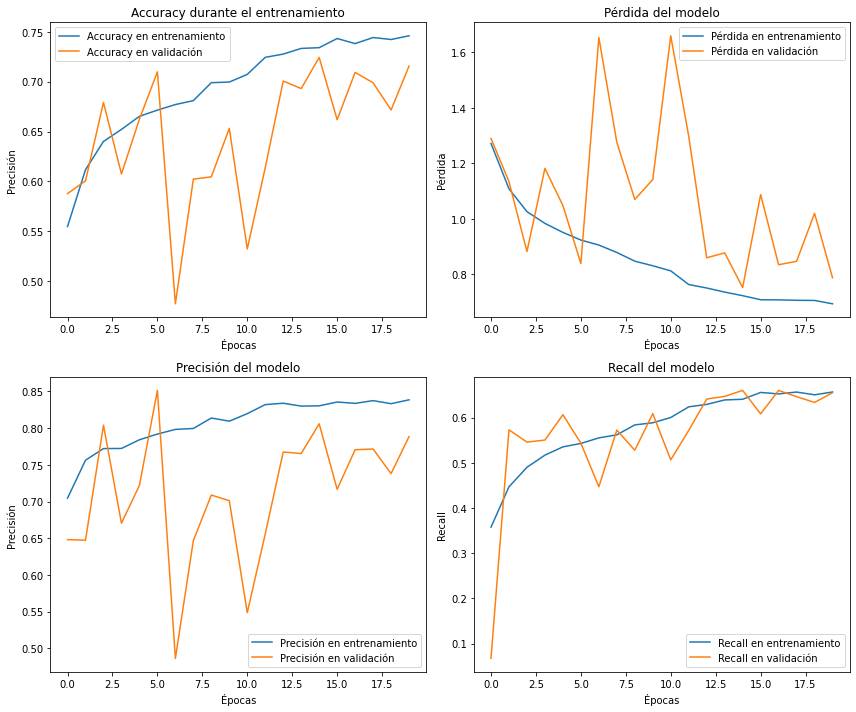

In [ ]:
# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  
plt.show()

**Evaluación**

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.5075 - auc: 0.8385 - f1_score: 0.8385 - loss: 1.2627 - precision: 0.5545 - recall: 0.4214
Pérdida en el conjunto de prueba: 0.7649876475334167
accuracy en el conjunto de prueba: 0.7269052863121033
Precision en el conjunto de prueba: 0.7988904118537903
Recall en el conjunto de prueba: 0.6651270389556885
AUC en el conjunto de prueba: 0.9412828683853149
F1-Score en el conjunto de prueba: 0.9412828683853149


In [ ]:
# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

In [ ]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step


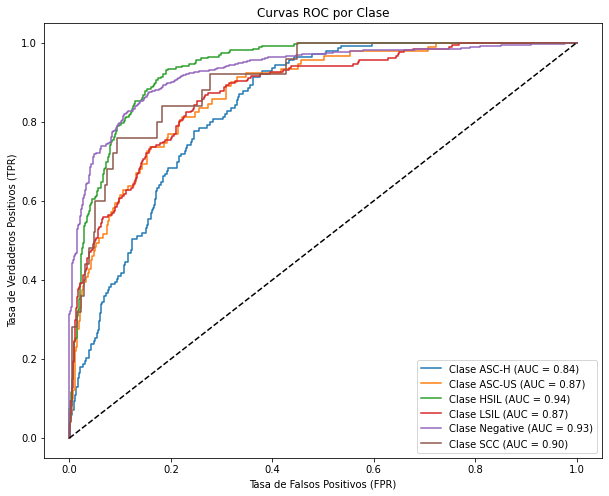

AUC Promedio: 0.89
AUC Promedio Ponderado: 0.91


In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')


### Modelo EfficientNetB5

In [ ]:
# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc')])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.4742 - auc: 0.7806 - f1_score: 0.7806 - loss: 1.3753 - precision: 0.7357 - recall: 0.2490 - val_accuracy: 0.5902 - val_auc: 0.8746 - val_f1_score: 0.8746 - val_loss: 1.2019 - val_precision: 0.6215 - val_recall: 0.5809 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.6635 - auc: 0.9053 - f1_score: 0.9053 - loss: 0.9611 - precision: 0.8197 - recall: 0.5245 - val_accuracy: 0.6838 - val_auc: 0.9265 - val_f1_score: 0.9265 - val_loss: 0.8537 - val_precision: 0.8646 - val_recall: 0.5462 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.6779 - auc: 0.9145 - f1_score: 0.9145 - loss: 0.9125 - precision: 0.8214 - recall: 0.5494 - val_accuracy: 0.7023 - val_auc: 0.9308 - val_f1_score: 0.9308 - val_loss: 0.8225 - val_precision: 0.8191 - val_recall: 0.6098 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accura

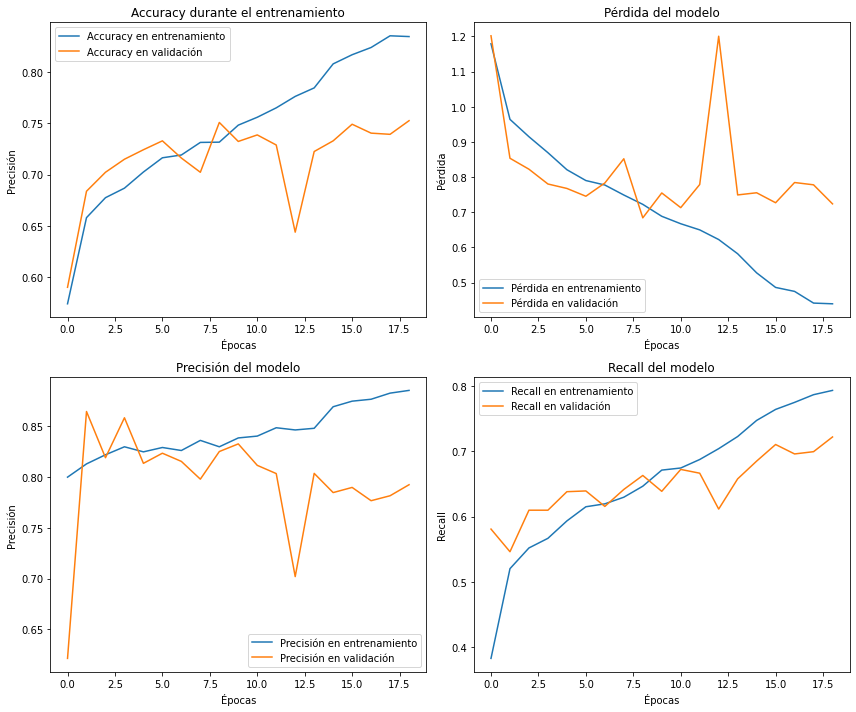

In [ ]:
# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout() 
plt.show()

**Evaluación**

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.5474 - auc: 0.8709 - f1_score: 0.8709 - loss: 1.1082 - precision: 0.6225 - recall: 0.4546
Pérdida en el conjunto de prueba: 0.7293526530265808
accuracy en el conjunto de prueba: 0.7332563400268555
Precision en el conjunto de prueba: 0.8291276097297668
Recall en el conjunto de prueba: 0.6639722585678101
AUC en el conjunto de prueba: 0.9466426372528076
F1-Score en el conjunto de prueba: 0.9466426372528076


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 242ms/step


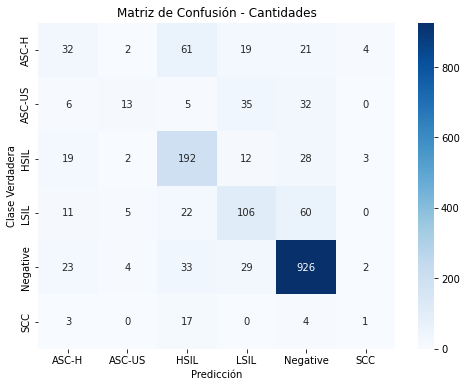

In [ ]:
# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

In [176]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.34      0.23      0.27       139
      ASC-US       0.50      0.14      0.22        91
        HSIL       0.58      0.75      0.66       256
        LSIL       0.53      0.52      0.52       204
    Negative       0.86      0.91      0.89      1017
         SCC       0.10      0.04      0.06        25

    accuracy                           0.73      1732
   macro avg       0.49      0.43      0.44      1732
weighted avg       0.71      0.73      0.71      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step


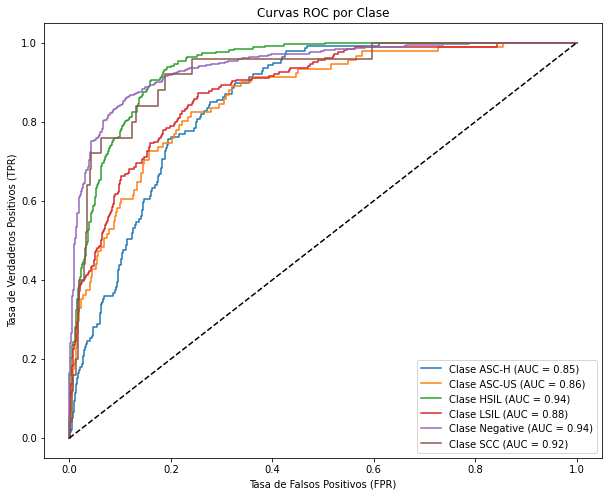

AUC Promedio: 0.90
AUC Promedio Ponderado: 0.92


In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

### Modelo MobileNetV2

In [ ]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

/var/folders/kl/780b8_9s0y35m4d8w8w07wfh0000gn/T/ipykernel_98935/770786427.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.5512 - auc: 0.8302 - f1_score: 0.8302 - loss: 1.2928 - precision: 0.6815 - recall: 0.4154 - val_accuracy: 0.6110 - val_auc: 0.8313 - val_f1_score: 0.8313 - val_loss: 2.5029 - val_precision: 0.6128 - val_recall: 0.6092 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.7086 - auc: 0.9338 - f1_score: 0.9338 - loss: 0.8087 - precision: 0.8233 - recall: 0.5972 - val_accuracy: 0.6682 - val_auc: 0.8887 - val_f1_score: 0.8887 - val_loss: 1.5626 - val_precision: 0.6843 - val_recall: 0.6439 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.7399 - auc: 0.9486 - f1_score: 0.9486 - loss: 0.7124 - precision: 0.8399 - recall: 0.6454 - val_accuracy: 0.7491 - val_auc: 0.9361 - val_f1_score: 0.9361 - val_loss: 0.8945 - val_precision: 0.7854 - val_recall: 0.7150 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - ac

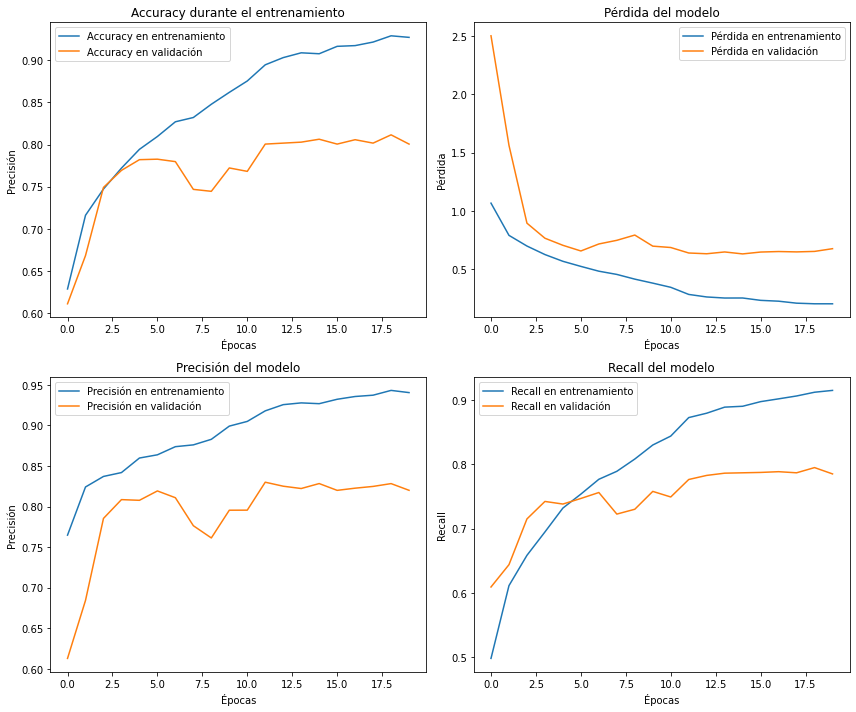

In [ ]:
# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10)) 

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  
plt.show()

**Evaluación**

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6760 - auc: 0.9219 - f1_score: 0.9219 - loss: 0.9933 - precision: 0.7103 - recall: 0.6523
Pérdida en el conjunto de prueba: 0.6191080808639526
accuracy en el conjunto de prueba: 0.795034646987915
Precision en el conjunto de prueba: 0.8236374855041504
Recall en el conjunto de prueba: 0.7765588760375977
AUC en el conjunto de prueba: 0.9641438126564026
F1-Score en el conjunto de prueba: 0.9641438126564026


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


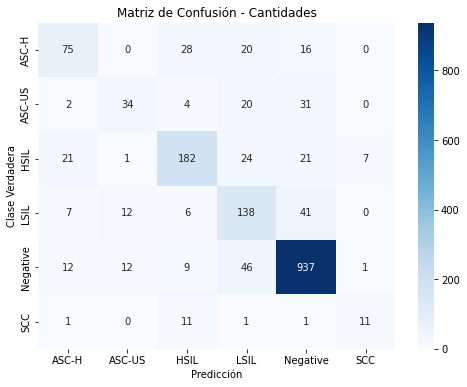

In [ ]:
# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

In [182]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.64      0.54      0.58       139
      ASC-US       0.58      0.37      0.45        91
        HSIL       0.76      0.71      0.73       256
        LSIL       0.55      0.68      0.61       204
    Negative       0.89      0.92      0.91      1017
         SCC       0.58      0.44      0.50        25

    accuracy                           0.80      1732
   macro avg       0.67      0.61      0.63      1732
weighted avg       0.79      0.80      0.79      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


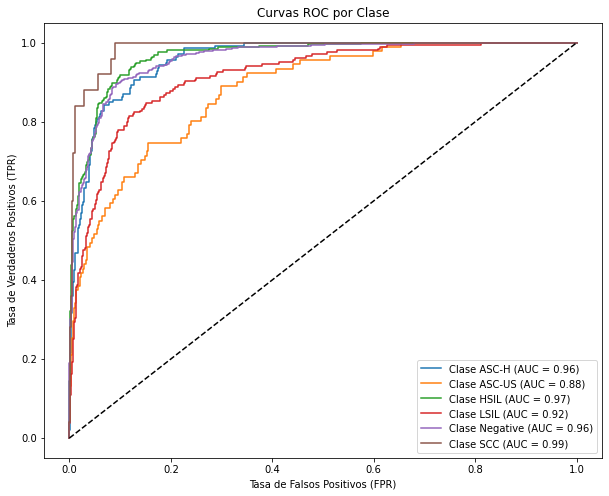

AUC Promedio: 0.94
AUC Promedio Ponderado: 0.95


In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

### Modelo MobileNetV3

In [ ]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - accuracy: 0.5981 - auc: 0.8650 - f1_score: 0.8650 - loss: 1.1342 - precision: 0.7479 - recall: 0.4572 - val_accuracy: 0.1474 - val_auc: 0.6380 - val_f1_score: 0.6380 - val_loss: 2.1461 - val_precision: 0.1476 - val_recall: 0.1474 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.6794 - auc: 0.9154 - f1_score: 0.9154 - loss: 0.9114 - precision: 0.8046 - recall: 0.5538 - val_accuracy: 0.1474 - val_auc: 0.6436 - val_f1_score: 0.6436 - val_loss: 1.8861 - val_precision: 0.1407 - val_recall: 0.1370 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.6931 - auc: 0.9225 - f1_score: 0.9225 - loss: 0.8737 - precision: 0.8063 - recall: 0.5731 - val_accuracy: 0.1792 - val_auc: 0.7461 - val_f1_score: 0.7461 - val_loss: 1.4574 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/s

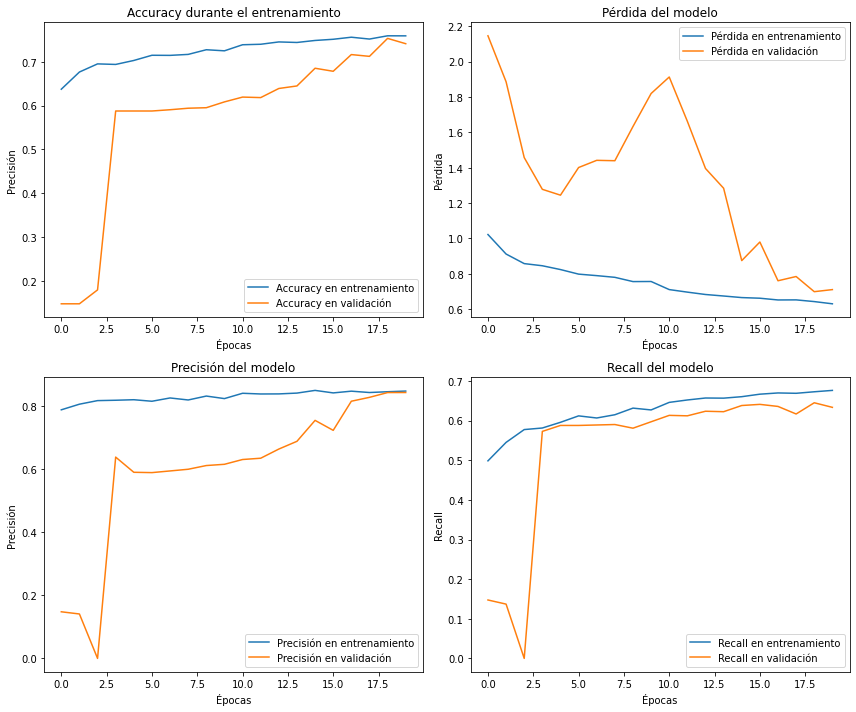

In [ ]:
# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout() 
plt.show()

**Evaluación**

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5274 - auc: 0.8698 - f1_score: 0.8698 - loss: 1.0835 - precision: 0.6201 - recall: 0.4191
Pérdida en el conjunto de prueba: 0.7101051211357117
accuracy en el conjunto de prueba: 0.7338337302207947
Precision en el conjunto de prueba: 0.8433459997177124
Recall en el conjunto de prueba: 0.6403002142906189
AUC en el conjunto de prueba: 0.9493201971054077
F1-Score en el conjunto de prueba: 0.9493201971054077


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


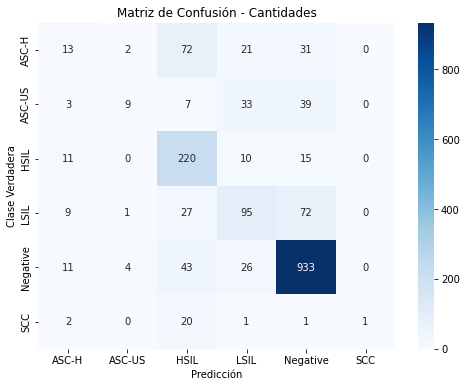

In [ ]:
# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

In [189]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.27      0.09      0.14       139
      ASC-US       0.56      0.10      0.17        91
        HSIL       0.57      0.86      0.68       256
        LSIL       0.51      0.47      0.49       204
    Negative       0.86      0.92      0.89      1017
         SCC       1.00      0.04      0.08        25

    accuracy                           0.73      1732
   macro avg       0.63      0.41      0.41      1732
weighted avg       0.71      0.73      0.70      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


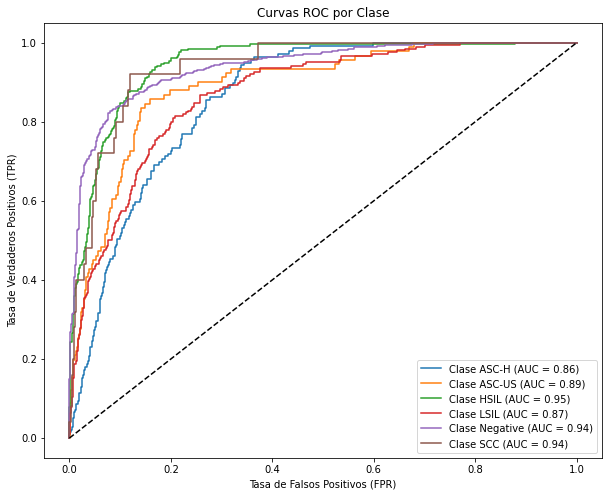

AUC Promedio: 0.91
AUC Promedio Ponderado: 0.92


In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

### Modelo InceptionV3

In [ ]:
# Importar y Definir el Modelo InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 65s 208ms/step - accuracy: 0.5836 - auc: 0.8347 - f1_score: 0.8347 - loss: 1.2408 - precision: 0.7195 - recall: 0.3802 - val_accuracy: 0.6908 - val_auc: 0.9244 - val_f1_score: 0.9244 - val_loss: 0.8738 - val_precision: 0.8327 - val_recall: 0.5983 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 54s 213ms/step - accuracy: 0.7033 - auc: 0.9266 - f1_score: 0.9266 - loss: 0.8549 - precision: 0.8371 - recall: 0.5804 - val_accuracy: 0.7376 - val_auc: 0.9471 - val_f1_score: 0.9471 - val_loss: 0.7279 - val_precision: 0.8440 - val_recall: 0.6318 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 57s 224ms/step - accuracy: 0.7404 - auc: 0.9471 - f1_score: 0.9471 - loss: 0.7272 - precision: 0.8469 - recall: 0.6392 - val_accuracy: 0.7561 - val_auc: 0.9549 - val_f1_score: 0.9549 - val_loss: 0.6713 - val_precision: 0.8520 - val_recall: 0.6723 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 56s 221ms/step 

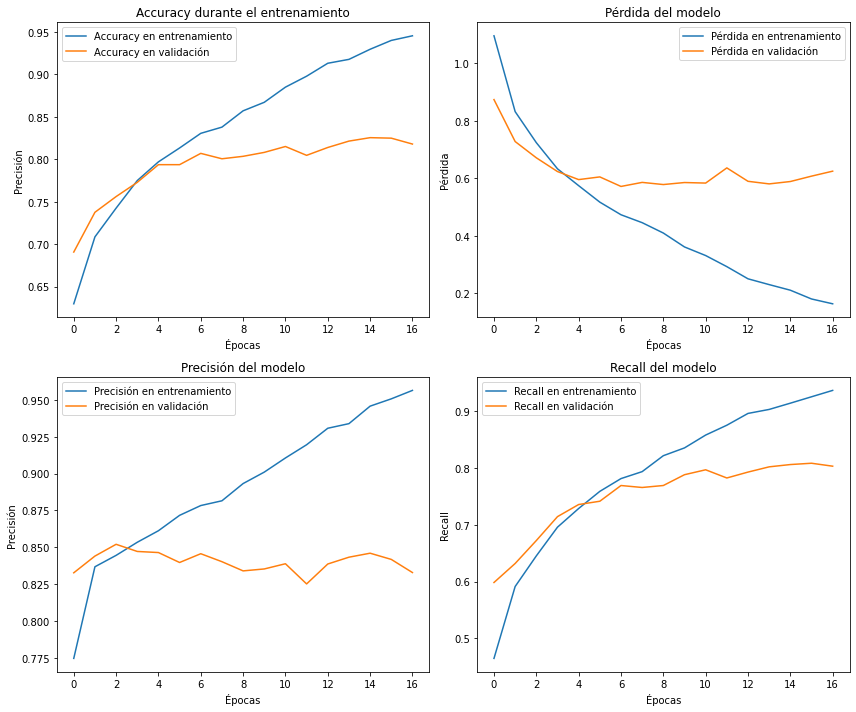

In [ ]:
# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10)) 

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  
plt.show()

**Evaluación**

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6756 - auc: 0.9168 - f1_score: 0.9168 - loss: 0.9214 - precision: 0.7102 - recall: 0.5976
Pérdida en el conjunto de prueba: 0.575361967086792
accuracy en el conjunto de prueba: 0.8100461959838867
Precision en el conjunto de prueba: 0.8480104207992554
Recall en el conjunto de prueba: 0.7505773901939392
AUC en el conjunto de prueba: 0.9657548069953918
F1-Score en el conjunto de prueba: 0.9657548069953918


55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step


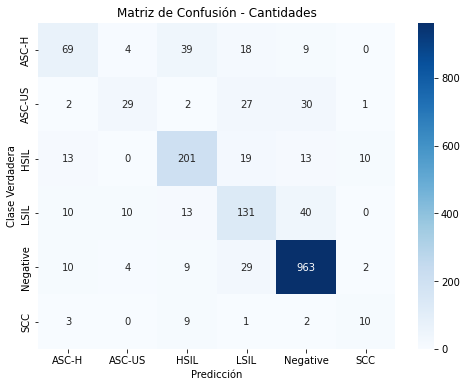

In [ ]:
# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

In [196]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.64      0.50      0.56       139
      ASC-US       0.62      0.32      0.42        91
        HSIL       0.74      0.79      0.76       256
        LSIL       0.58      0.64      0.61       204
    Negative       0.91      0.95      0.93      1017
         SCC       0.43      0.40      0.42        25

    accuracy                           0.81      1732
   macro avg       0.65      0.60      0.62      1732
weighted avg       0.80      0.81      0.80      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step


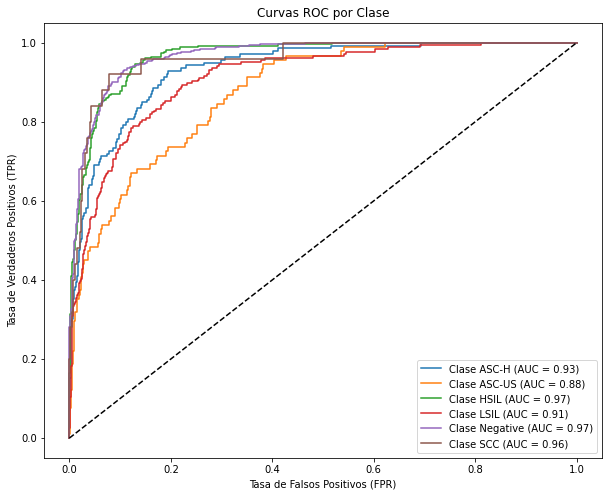

AUC Promedio: 0.94
AUC Promedio Ponderado: 0.95


In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

### Modelo Xception

In [ ]:
# Pesos de clase para manejar el desbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Cargar el modelo base Xception preentrenado en ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True  # Habilitamos el fine-tuning completo

# Congelar las primeras capas para evitar sobreajuste rápido
fine_tune_at = 75
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Definir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc')])
                    # tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights,  # Aplicar los pesos de clase
    callbacks=[early_stopping, reduce_lr]
)


In [22]:
model.save('xception_clasificacion6clases.keras')

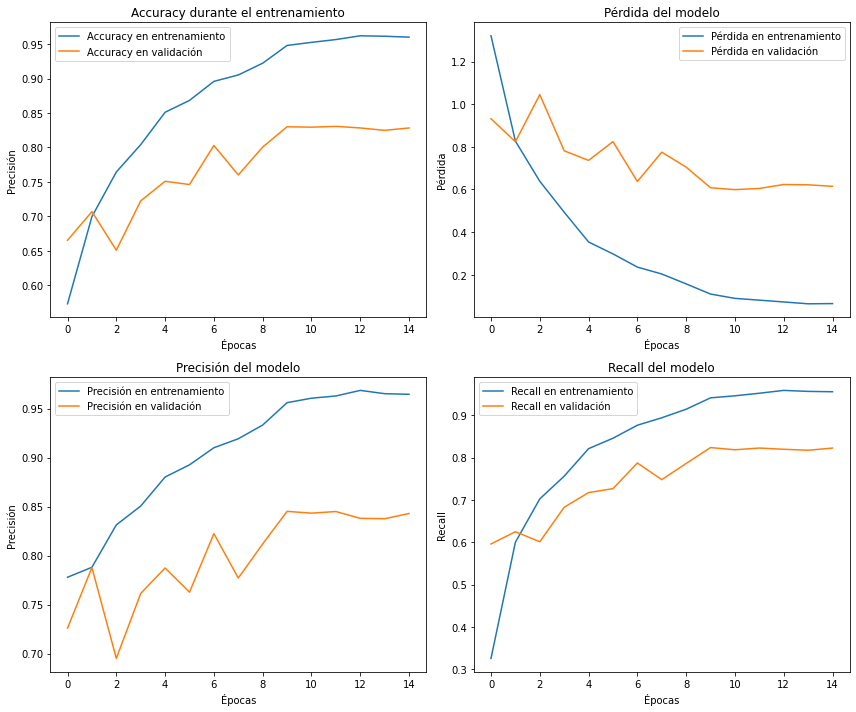

In [ ]:
# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10)) 

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()

**Evaluación**

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.7653 - auc: 0.9555 - f1_score: 0.9555 - loss: 0.7579 - precision: 0.7819 - recall: 0.7475
Pérdida en el conjunto de prueba: 0.5629568099975586
accuracy en el conjunto de prueba: 0.8140877485275269
Precision en el conjunto de prueba: 0.8309352397918701
Recall en el conjunto de prueba: 0.8002309203147888
AUC en el conjunto de prueba: 0.9721276760101318
F1-Score en el conjunto de prueba: 0.9721276760101318


55/55 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step


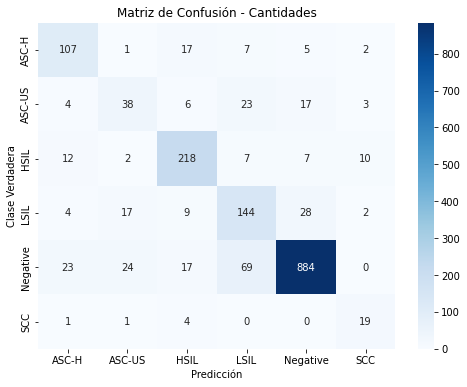

In [ ]:
# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

55/55 ━━━━━━━━━━━━━━━━━━━━ 54s 967ms/step


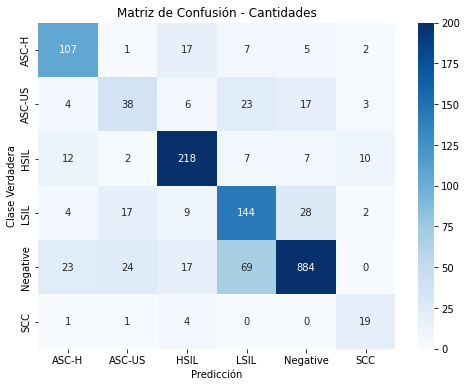

In [ ]:
# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión con escala limitada
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d', vmax=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels, vmax=vmax)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades y escala limitada
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades', vmax=200)

In [214]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.71      0.77      0.74       139
      ASC-US       0.46      0.42      0.44        91
        HSIL       0.80      0.85      0.83       256
        LSIL       0.58      0.71      0.63       204
    Negative       0.94      0.87      0.90      1017
         SCC       0.53      0.76      0.62        25

    accuracy                           0.81      1732
   macro avg       0.67      0.73      0.69      1732
weighted avg       0.83      0.81      0.82      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step


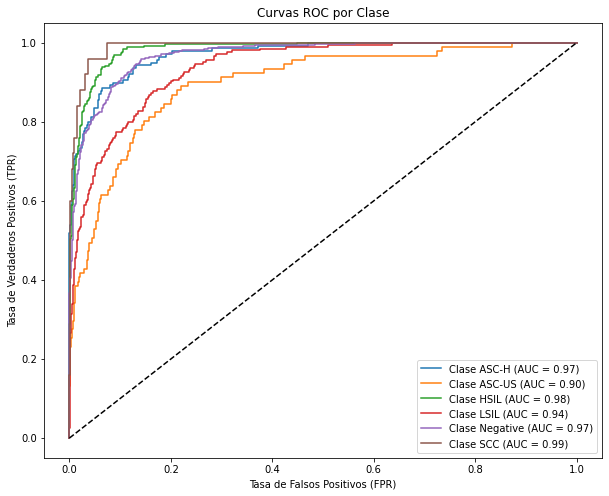

AUC Promedio: 0.96
AUC Promedio Ponderado: 0.96


In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

#### Evaluación de modelo guardado

55/55 ━━━━━━━━━━━━━━━━━━━━ 54s 961ms/step - accuracy: 0.7857 - auc: 0.9497 - f1_score: 0.9497 - loss: 0.7997 - precision: 0.8007 - recall: 0.7662
Precisión en el conjunto de prueba: 0.8314
Recall en el conjunto de prueba: 0.8187
Precision en el conjunto de prueba: 0.8456
AUC en el conjunto de prueba: 0.9691
F1-Score en el conjunto de prueba: 0.9690746665000916
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step
              precision    recall  f1-score   support

       ASC-H       0.68      0.81      0.74       139
      ASC-US       0.50      0.41      0.45        91
        HSIL       0.82      0.85      0.83       256
        LSIL       0.62      0.71      0.66       204
    Negative       0.95      0.89      0.92      1017
         SCC       0.51      0.72      0.60        25

    accuracy                           0.83      1732
   macro avg       0.68      0.73      0.70      1732
weighted avg       0.84      0.83      0.83      1732



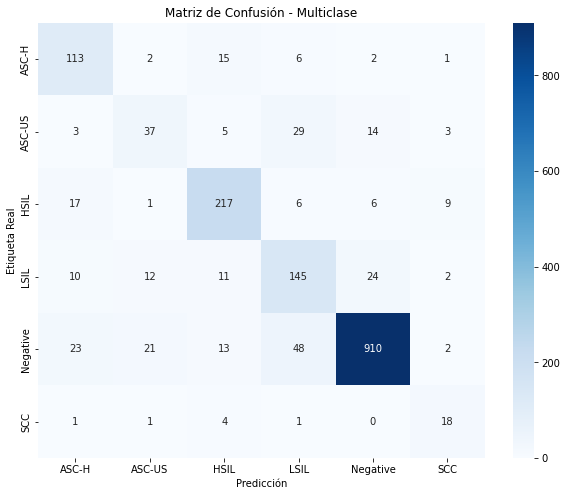

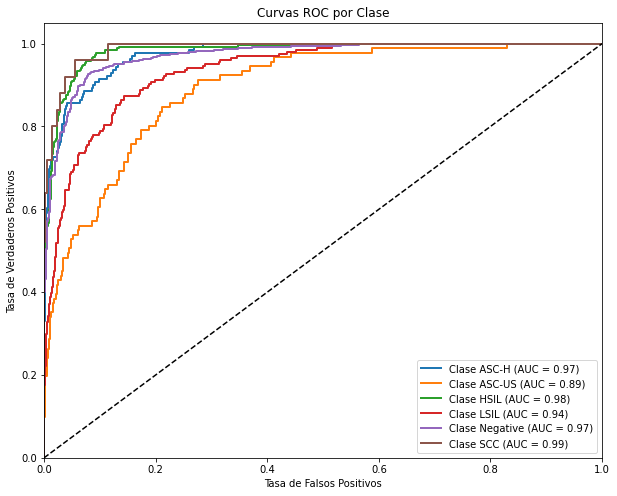

In [ ]:
# Cargar el modelo guardado
model = tf.keras.models.load_model('modelosFinales/xception_clasificacion6clases.keras')

# Evaluar el modelo en el conjunto de prueba
evaluation_metrics = model.evaluate(test_generator)

# Asumiendo que tienes 5 métricas (loss, accuracy, precision, recall, auc)
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = evaluation_metrics
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")
print(f"Recall en el conjunto de prueba: {test_recall:.4f}")
print(f"Precision en el conjunto de prueba: {test_precision:.4f}")
print(f"AUC en el conjunto de prueba: {test_auc:.4f}")
print(f'F1-Score en el conjunto de prueba: {test_f1}')

# Generar predicciones y etiquetas verdaderas
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# Nombres de las clases
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión - Multiclase')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# Curvas ROC y precisión-recall para cada clase con el mejor threshold
best_thresholds = {}

# Curvas ROC por clase
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Clase {label} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()


## 4. Entrenamiento y evaluación de modelo final con aumentación de datos

### Generación de datos con aumentación

In [ ]:
# import os
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
# from tqdm import tqdm
# import shutil  # Para copiar imágenes originales

# # Directorios de origen y destino
# train_dir = "imgs/crops_6classes/train"
# augmented_dir = "imgs/crops_6classes_aug/train"

# # Crear directorios de destino si no existen
# os.makedirs(augmented_dir, exist_ok=True)

# # Transformaciones base
# datagen = ImageDataGenerator(
#     rescale=1.0 / 255,
#     rotation_range=10,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     horizontal_flip=True,
#     vertical_flip=True,
#     zoom_range=0.1,
#     fill_mode="nearest"
# )

# # Configuración de aumentación personalizada por clase
# augmentation_multipliers = {
#     "Negative": 0,  # No aumentar (ya tiene suficientes muestras)
#     "HSIL": 2,  # Aumentar el dataset 2x
#     "LSIL": 3,  # Aumentar el dataset 3x
#     "ASC-H": 4,  # Aumentar el dataset 4x 
#     "ASC-US": 5,  # Aumentar el dataset 5x
#     "SCC": 8,  # Aumentar el dataset 8x (clase más minoritaria)
# }

# # Recorrer las carpetas de cada clase
# for class_name in os.listdir(train_dir):
#     class_path = os.path.join(train_dir, class_name)
#     if not os.path.isdir(class_path):
#         continue

#     # Crear carpeta para la clase en el destino
#     save_path = os.path.join(augmented_dir, class_name)
#     os.makedirs(save_path, exist_ok=True)

#     # Contar las imágenes originales y calcular cuántas generar
#     images = os.listdir(class_path)
#     multiplier = augmentation_multipliers.get(class_name, 0)

#     print(f"Procesando clase: {class_name} | Imágenes originales: {len(images)} | Multiplicador: {multiplier}")

#     # Copiar las imágenes originales si no se necesita aumentación
#     if multiplier == 0:
#         for img_name in tqdm(images, desc=f"Copiando originales - {class_name}"):
#             img_path = os.path.join(class_path, img_name)
#             shutil.copy(img_path, save_path)  # Copiar la imagen original con su nombre original
#     else:
#         # Copiar las imágenes originales a la carpeta destino
#         for img_name in tqdm(images, desc=f"Copiando originales - {class_name}"):
#             img_path = os.path.join(class_path, img_name)
#             shutil.copy(img_path, save_path)

#         # Generar imágenes aumentadas
#         for img_name in tqdm(images, desc=f"Generando aumentadas - {class_name}"):
#             img_path = os.path.join(class_path, img_name)
#             img = load_img(img_path)
#             img_array = img_to_array(img)
#             img_array = img_array.reshape((1,) + img_array.shape)

#             # Generar imágenes aumentadas
#             i = 0
#             for batch in datagen.flow(img_array, batch_size=1):
#                 aug_img_path = os.path.join(save_path, f"aug_{i}_{img_name}")
#                 save_img(aug_img_path, batch[0])
#                 i += 1
#                 if i >= multiplier - 1:  # Generar exactamente (multiplier - 1) imágenes por imagen original
#                     break

# print("Aumentación completada. Las imágenes originales y aumentadas se han guardado en la carpeta imgs/crops_6classes_aug.")


Procesando clase: HSIL | Imágenes originales: 1192 | Multiplicador: 2


Generando aumentadas - HSIL: 100%|██████████| 1192/1192 [00:09<00:00, 119.95it/s]


Procesando clase: LSIL | Imágenes originales: 952 | Multiplicador: 3


Generando aumentadas - LSIL: 100%|██████████| 952/952 [00:15<00:00, 62.41it/s]


Procesando clase: Negative | Imágenes originales: 4745 | Multiplicador: 0


Copiando originales - Negative: 100%|██████████| 4745/4745 [00:02<00:00, 2137.82it/s]


Procesando clase: ASC-H | Imágenes originales: 647 | Multiplicador: 4


Generando aumentadas - ASC-H: 100%|██████████| 647/647 [00:19<00:00, 33.10it/s]


Procesando clase: ASC-US | Imágenes originales: 424 | Multiplicador: 5


Generando aumentadas - ASC-US: 100%|██████████| 424/424 [00:12<00:00, 32.76it/s]


Procesando clase: SCC | Imágenes originales: 112 | Multiplicador: 8


Generando aumentadas - SCC: 100%|██████████| 112/112 [00:05<00:00, 18.69it/s]

Aumentación completada. Las imágenes originales y aumentadas se han guardado en la carpeta crops_6classes_aug.


Conteo de imágenes originales por clase: {'HSIL': 1192, 'LSIL': 952, 'Negative': 4745, 'ASC-H': 647, 'ASC-US': 424, 'SCC': 112}
Conteo de imágenes aumentadas por clase: {'HSIL': 1192, 'LSIL': 1904, 'Negative': 0, 'ASC-H': 1941, 'ASC-US': 1696, 'SCC': 784}


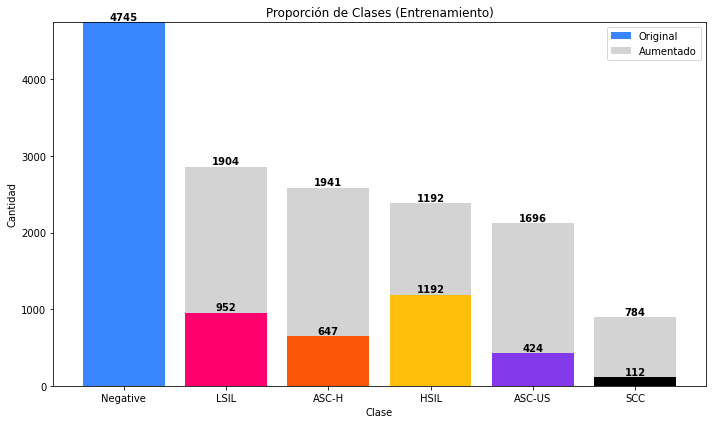

In [ ]:
# Función para contar imágenes originales y aumentadas por clase
def count_images_by_class_with_augmentation(folder_path):
    class_counts = {}
    augmented_counts = {}

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([img for img in os.listdir(class_path) if "aug_" not in img])
            augmented_counts[class_name] = len([img for img in os.listdir(class_path) if "aug_" in img])

    return class_counts, augmented_counts

# Función para crear el gráfico de barras del conjunto de entrenamiento
def plot_class_proportion_with_augmentation(class_counts, augmented_counts, title, colors):
    # Ordenar las clases por cantidad total (originales + aumentadas)
    total_counts = {cls: class_counts[cls] + augmented_counts[cls] for cls in class_counts}
    sorted_classes = sorted(total_counts.keys(), key=lambda x: total_counts[x], reverse=True)
    
    # Reorganizar datos según el nuevo orden
    classes = sorted_classes
    counts = [class_counts[cls] for cls in classes]
    augmented = [augmented_counts[cls] for cls in classes]
    sorted_colors = colors[:len(classes)]

    # Graficar datos originales y aumentados
    fig, ax = plt.subplots(figsize=(10, 6))
    bars_original = ax.bar(classes, counts, color=sorted_colors, label='Original')
    bars_augmented = ax.bar(classes, augmented, bottom=counts, color='#D3D3D3', label='Aumentado')

    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)

    # Agregar etiquetas de cantidad en las barras
    for bar, count in zip(bars_original, counts):
        ax.text(bar.get_x() + bar.get_width() / 2, count + 5, str(count), ha='center', va='bottom', fontweight='bold')
    
    for bar, count, aug in zip(bars_augmented, counts, augmented):
        if aug > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, count + aug + 5, str(aug), ha='center', va='bottom', fontweight='bold')

    # Añadir leyenda y mostrar gráfico
    ax.legend()
    plt.tight_layout()
    plt.show()

# Directorio de entrenamiento
train_dir = 'imgs/crops_6classes_aug/train'

# Contar las imágenes
train_class_counts, train_augmented_counts = count_images_by_class_with_augmentation(train_dir)

# Debugging: Imprimir conteos
print("Conteo de imágenes originales por clase:", train_class_counts)
print("Conteo de imágenes aumentadas por clase:", train_augmented_counts)

# Colores para las clases
colors = ['#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC', '#000000']

# Graficar
plot_class_proportion_with_augmentation(train_class_counts, train_augmented_counts, 'Proporción de Clases (Entrenamiento)', colors)


### Generador para datos de train balanceados

In [ ]:
# Configuración de parámetros
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de aumentación para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

# Crear generadores para entrenamiento, validación y prueba
train_generator_aug = train_datagen.flow_from_directory(
    'imgs/crops_6classes_aug/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 15589 images belonging to 6 classes.


### Xception

In [ ]:
# Configuración de parámetros
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = len(train_generator_aug.class_indices)

# Pesos de clase para manejar el desbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator_aug.classes),
    y=train_generator_aug.classes
)
class_weights = dict(enumerate(class_weights))

# Cargar el modelo base Xception preentrenado en ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True  # Habilitamos el fine-tuning completo

# Congelar las primeras capas para evitar sobreajuste rápido
fine_tune_at = 75
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Definir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc')])
                    # tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights,  # Aplicar los pesos de clase
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


488/488 ━━━━━━━━━━━━━━━━━━━━ 1309s 3s/step - accuracy: 0.5175 - auc: 0.8337 - loss: 1.2285 - precision: 0.7264 - recall: 0.2932 - val_accuracy: 0.7913 - val_auc: 0.9629 - val_loss: 0.6030 - val_precision: 0.8334 - val_recall: 0.7405 - learning_rate: 1.0000e-04
Epoch 2/30
488/488 ━━━━━━━━━━━━━━━━━━━━ 2448s 5s/step - accuracy: 0.7849 - auc: 0.9653 - loss: 0.5486 - precision: 0.8397 - recall: 0.7270 - val_accuracy: 0.8358 - val_auc: 0.9722 - val_loss: 0.5131 - val_precision: 0.8535 - val_recall: 0.8150 - learning_rate: 1.0000e-04
Epoch 3/30
488/488 ━━━━━━━━━━━━━━━━━━━━ 1712s 3s/step - accuracy: 0.8675 - auc: 0.9862 - loss: 0.3194 - precision: 0.8916 - recall: 0.8451 - val_accuracy: 0.8335 - val_auc: 0.9679 - val_loss: 0.6022 - val_precision: 0.8518 - val_recall: 0.8237 - learning_rate: 1.0000e-04
Epoch 4/30
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9170 - auc: 0.9937 - loss: 0.2029 - precision: 0.9318 - recall: 0.9032
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.9999

In [31]:
model.save('xception_clasificacion6clases_balanceado.keras')

**Evaluacion**

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7764 - auc: 0.9472 - loss: 0.8050 - precision: 0.7921 - recall: 0.7640
Pérdida en el conjunto de prueba: 0.5329932570457458
accuracy en el conjunto de prueba: 0.8475750684738159
Precision en el conjunto de prueba: 0.860946774482727
Recall en el conjunto de prueba: 0.8400692939758301
AUC en el conjunto de prueba: 0.9718738794326782


55/55 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step


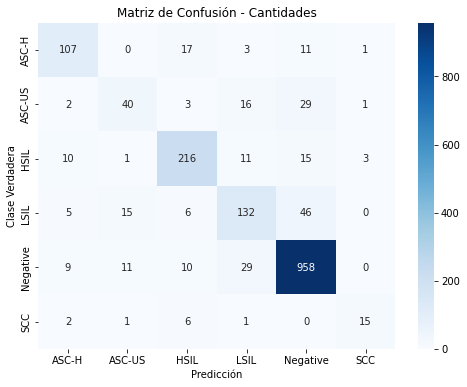

In [ ]:
# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

In [ ]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.79      0.77      0.78       139
      ASC-US       0.59      0.44      0.50        91
        HSIL       0.84      0.84      0.84       256
        LSIL       0.69      0.65      0.67       204
    Negative       0.90      0.94      0.92      1017
         SCC       0.75      0.60      0.67        25

    accuracy                           0.85      1732
   macro avg       0.76      0.71      0.73      1732
weighted avg       0.84      0.85      0.84      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step


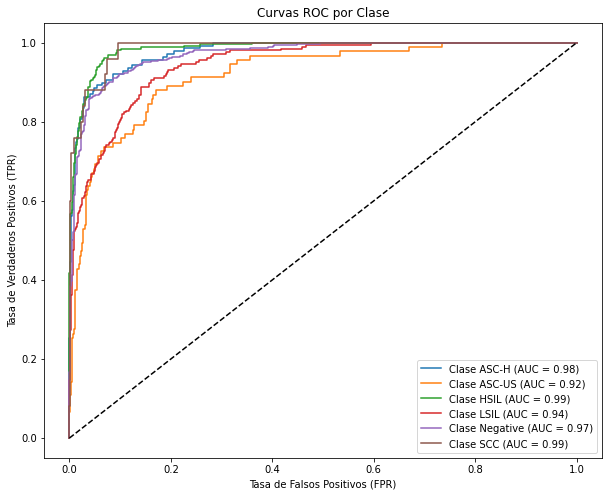

AUC Promedio: 0.96
AUC Promedio Ponderado: 0.97


In [ ]:
# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.7764 - auc: 0.9472 - loss: 0.8050 - precision: 0.7921 - recall: 0.7640
Precisión en el conjunto de prueba: 0.8476
Recall en el conjunto de prueba: 0.8401
Precision en el conjunto de prueba: 0.8609
AUC en el conjunto de prueba: 0.9719
55/55 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step
              precision    recall  f1-score   support

       ASC-H       0.79      0.77      0.78       139
      ASC-US       0.59      0.44      0.50        91
        HSIL       0.84      0.84      0.84       256
        LSIL       0.69      0.65      0.67       204
    Negative       0.90      0.94      0.92      1017
         SCC       0.75      0.60      0.67        25

    accuracy                           0.85      1732
   macro avg       0.76      0.71      0.73      1732
weighted avg       0.84      0.85      0.84      1732



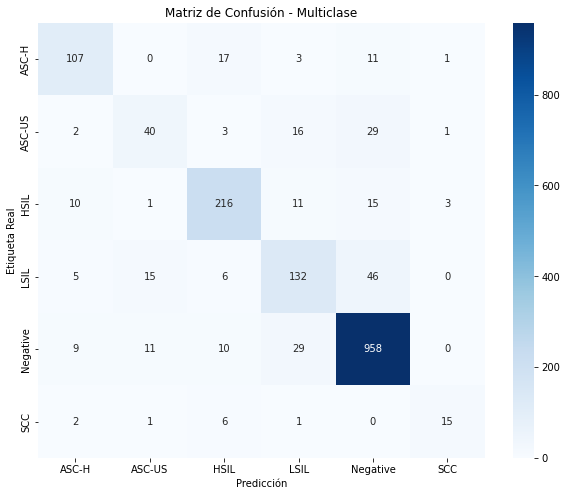

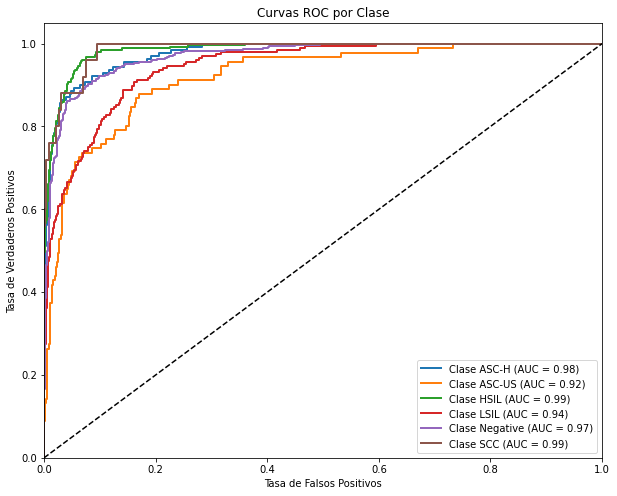

In [ ]:
# Cargar el modelo guardado
model = tf.keras.models.load_model('modelosFinales/xception_clasificacion6clases_balanceado.keras')

# Evaluar el modelo en el conjunto de prueba
evaluation_metrics = model.evaluate(test_generator)

# Asumiendo que tienes 5 métricas (loss, accuracy, precision, recall, auc)
test_loss, test_acc, test_precision, test_recall, test_auc = evaluation_metrics
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")
print(f"Recall en el conjunto de prueba: {test_recall:.4f}")
print(f"Precision en el conjunto de prueba: {test_precision:.4f}")
print(f"AUC en el conjunto de prueba: {test_auc:.4f}")

# Generar predicciones y etiquetas verdaderas
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# Nombres de las clases
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión - Multiclase')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# Curvas ROC y precisión-recall para cada clase con el mejor threshold
best_thresholds = {}

# Curvas ROC por clase
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Clase {label} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()


## 5. Búsqueda de hiperparámetros para mejor modelo

In [ ]:
# Configuración de datos
IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = len(train_generator_aug.class_indices)

# Calcular pesos de clase
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator_aug.classes),
    y=train_generator_aug.classes
)
class_weights = dict(enumerate(class_weights))

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)

# Definir HyperModel
class XceptionHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        # Modelo base
        base_model = Xception(weights='imagenet', include_top=False, input_shape=self.input_shape)
        base_model.trainable = True

        # Hiperparámetro para ajustar cuántas capas congelar
        fine_tune_at = hp.Choice('fine_tune_at', [50, 75, 100])
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        # Construcción del modelo
        inputs = Input(shape=self.input_shape)
        x = base_model(inputs, training=True)
        x = GlobalAveragePooling2D()(x)

        # Hiperparámetro para decidir si agregar una capa densa adicional
        num_dense_layers = hp.Choice('num_dense_layers', [0, 1])
        if num_dense_layers == 1:
            x = Dense(hp.Choice('dense_units', [256, 512, 1024]), activation='relu')(x)
            x = Dropout(hp.Choice('dropout_rate', [0.3, 0.5, 0.6]))(x)

        # Capa de salida
        outputs = Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs)

        # Compilar el modelo
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 5e-5, 1e-5])),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
        )
        return model

# Inicializar HyperModel
hypermodel = XceptionHyperModel(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)

# Configurar Keras Tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_recall',  # Optimizar por recall
    max_trials=5,  # Número de combinaciones a probar
    executions_per_trial=1,  # Número de ejecuciones por combinación
    directory='hyperparameter_search',
    project_name='xception_6_classes'
)

# Realizar búsqueda
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nMejores Hiperparámetros:")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate') if best_hps.get('num_dense_layers') == 1 else 'N/A'}")
print(f"Fine-tune layers: {best_hps.get('fine_tune_at')}")
print(f"Dense Units: {best_hps.get('dense_units') if best_hps.get('num_dense_layers') == 1 else 'N/A'}")
print(f"Number of Dense Layers: {best_hps.get('num_dense_layers')}")

# Entrenar el modelo con los mejores hiperparámetros
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluar el modelo
results = best_model.evaluate(val_generator)
print("\nResultados del mejor modelo:")
print(results)